In [2]:
import pandas as pd
import numpy as np

In [5]:
dataSet = pd.read_csv('C:\\Users\\choven\\Desktop\\scoreCard\\J03ScoreCard\\A_Card\\application.csv',encoding='latin1') #Latin1是ISO-8859-1的别名,单字节编码

In [6]:
dataSet.shape

(39785, 25)

In [7]:
dataSet.head(3)

,member_id,loan_amnt,term,loan_status,int_rate,emp_length,home_ownership,annual_inc,verification_status,desc,...,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,pub_rec_bankruptcies,issue_d,earliest_cr_line
0,1,5000,36 months,Fully Paid,10.65%,10+ years,RENT,24000.0,Verified,Borrower added on 12/22/11 > I need to upgra...,...,0,1,NaN,NaN,3,0,9,0.0,Dec-11,Jan-85
1,2,2500,60 months,Charged Off,15.27%,< 1 year,RENT,30000.0,Source Verified,Borrower added on 12/22/11 > I plan to use t...,...,0,5,NaN,NaN,3,0,4,0.0,Dec-11,Apr-99
2,3,2400,36 months,Fully Paid,15.96%,10+ years,RENT,12252.0,Not Verified,NaN,...,0,2,NaN,NaN,2,0,10,0.0,Dec-11,Nov-01


In [8]:
# 去掉 month，只保留数字
dataSet['term'] = dataSet['term'].apply(lambda x: int(x.replace(' months', '')))

In [9]:
# 处理标签：Fully Paid是正常用户；Charged Off是违约用户
# (charged off:1,fully paid:0)
dataSet['y'] = dataSet['loan_status'].map(lambda x: int(x == 'Charged Off')) # int(True) == 1, int(Fales) == 0

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
'''
由于存在不同的贷款期限（term），申请评分卡模型评估的违约概率必须要在统一的期限中，且不宜太长，所以选取term＝36months的行本
'''

dataCopy = dataSet.loc[dataSet.term == 36]

trainData, testData = train_test_split(dataCopy, test_size=0.4)

In [12]:
dataCopy.shape

(29095, 26)

In [13]:
trainData.shape

(17457, 26)

In [14]:
testData.shape

(11638, 26)

In [ ]:
# 固化变量
trainDataFile = open(folderOfData + 'trainData.pkl', 'wb+')
pickle.dump(trainData, trainDataFile)
trainDataFile.close()

testDataFile = open(folderOfData + 'testData.pkl', 'wb+')
pickle.dump(testData, testDataFile)
testDataFile.close()

## 第一步：数据预处理

1. 数据清洗

2. 格式转换

3. 确实值填补


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# 将带％的百分比变为浮点数
trainData['int_rate_clean'] = trainData['int_rate'].map(lambda x: float(x.replace('%', '')) / 100)

In [17]:
trainData.emp_length.value_counts()

10+ years    3509
< 1 year     2189
2 years      2018
3 years      1824
1 year       1569
4 years      1561
5 years      1431
6 years       956
7 years       727
8 years       641
9 years       555
Name: emp_length, dtype: int64

In [18]:
# 将工作年限进行转化，否则影响排序
import re
def CareerYear(x):
    #对工作年限进行转换
    x = str(x)
    # str.find(subsStr)  # 如果包含子字符串返回开始的索引值，否则返回-1。
    if x.find('nan') > -1:
        return -1
    elif x.find("10+")>-1:   #将"10＋years"转换成 11
        return 11
    elif x.find('< 1') > -1:  #将"< 1 year"转换成 0
        return 0
    else:
        return int(re.sub("\D", "", x))   #其余数据，去掉"years"并转换成整数
    
    
trainData['emp_length_clean'] = trainData['emp_length'].map(CareerYear)

In [19]:
# 将desc的缺失作为一种状态，非缺失作为另一种状态
def DescExisting(x):
    #将desc变量转换成有记录和无记录两种
    # type(np.nan) == float
    if type(x).__name__ == 'float':
        return 'no desc'
    else:
        return 'desc'
    
    
trainData['desc_clean'] = trainData['desc'].map(DescExisting)

In [20]:
# 处理日期。earliest_cr_line的格式不统一，需要统一格式且转换成python的日期

import datetime
import time
def ConvertDateStr(x):
    mth_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                'Nov': 11, 'Dec': 12}
    if str(x) == 'nan':   # str(np.nan) == 'nan'
        # time.mktime() 返回用秒数来表示时间的浮点数 (字符串时间转时间戳)
        # datetime.fromtimestamp（） 时间戳转datatime对象
        return datetime.datetime.fromtimestamp(time.mktime(time.strptime('3000-1','%Y-%m')))
        #time.mktime 不能读取1970年之前的日期
    else:
        yr = int(x[4:6])  # str[4:6]  选取字符串[4:6]位置的数
        if yr <=17:
            yr = 2000+yr
        else:
            yr = 1900 + yr
        mth = mth_dict[x[:3]]
        return datetime.datetime(yr,mth,1)
    
    
trainData['app_date_clean'] = trainData['issue_d'].map(lambda x: ConvertDateStr(x))
trainData['earliest_cr_line_clean'] = trainData['earliest_cr_line'].map(lambda x: ConvertDateStr(x))


In [21]:
# 处理mths_since_last_delinq。注意原始值中有空值，所以用－1代替缺失

def MakeupMissing(x):
    if np.isnan(x):
        return -1
    else:
        return x
    
    
trainData['mths_since_last_delinq_clean'] = trainData['mths_since_last_delinq'].map(lambda x: MakeupMissing(x))

trainData['mths_since_last_record_clean'] = trainData['mths_since_last_record'].map(lambda x: MakeupMissing(x))

trainData['pub_rec_bankruptcies_clean'] = trainData['pub_rec_bankruptcies'].map(lambda x: MakeupMissing(x))


## 第二步：变量衍生

In [22]:

# 考虑申请额度与收入的占比
trainData['limit_income'] = trainData.apply(lambda x: x.loan_amnt / x.annual_inc, axis = 1)

# 考虑earliest_cr_line到申请日期的跨度，以月份记
from dateutil.relativedelta import relativedelta

def MonthGap(earlyDate, lateDate):
    if lateDate > earlyDate:
        gap = relativedelta(lateDate,earlyDate)
        
        yr = gap.years
        mth = gap.months
        return yr*12+mth
    else:
        return 0
    
trainData['earliest_cr_to_app'] = trainData.apply(lambda x: MonthGap(x.earliest_cr_line_clean,x.app_date_clean), axis = 1)


## 第三步：分箱，采用ChiMerge,要求分箱完之后：

1. 不超过5箱

2. Bad Rate单调

3. 每箱同时包含好坏样本

4. 特殊值如－1，单独成一箱

连续型变量可直接分箱

类别型变量：

1. 当取值较多时，先用bad rate编码，再用连续型分箱的方式进行分箱

2. 当取值较少时：

    （1）如果每种类别同时包含好坏样本，无需分箱
    
    （2）如果有类别只包含好坏样本的一种，需要合并


In [23]:
num_features = ['int_rate_clean', 'emp_length_clean', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_to_app',
                'inq_last_6mths', 
                'mths_since_last_record_clean', 'mths_since_last_delinq_clean', 'open_acc', 'pub_rec', 'total_acc',
                'limit_income', 'earliest_cr_to_app']

cat_features = ['home_ownership', 'verification_status', 'desc_clean', 'purpose', 'zip_code', 'addr_state',
                'pub_rec_bankruptcies_clean']

more_value_features = []  # 类别标签中unique值 > 5
less_value_features = []  # 类别标签中unique值 < 5

### 第一步，检查类别型变量中，哪些变量取值超过5

In [24]:

for var in cat_features:
    valueCounts = len(set(trainData[var]))
    #print(valueCounts)
    if valueCounts > 5:
        more_value_features.append(var)  # 取值超过5的变量，需要bad rate编码，再用卡方分箱法进行分箱
    else:
        less_value_features.append(var)

In [42]:
"""
test
"""

print("离散型标签中unique>5的more_value_features：")
print("    ",more_value_features)
print('---------------------')
print("离散型标签中unique<5的less_value_features：")
print("    ",less_value_features)


离散型标签中unique>5的more_value_features：
     ['purpose', 'zip_code', 'addr_state']
---------------------
离散型标签中unique<5的less_value_features：
     ['verification_status', 'desc_clean']


In [27]:
def BinBadRate(df, col, target, grantRateIndicator=0):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left') # 每箱的坏样本数，总样本数
    regroup.reset_index(level=0, inplace=True)  # 更改索引
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1) # 加上一列坏样本率
    dicts = dict(zip(regroup[col],regroup['bad_rate'])) # col箱对应的坏样本率组成的字典
    if grantRateIndicator==0:
        return (dicts,regroup)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    overallRate = B * 1.0 / N
    return (dicts, regroup, overallRate)

In [28]:
"""
test 
# BinBadRate
"""
regroup = BinBadRate(trainData,'pub_rec_bankruptcies_clean','y')[1].sort_values(by = 'bad_rate')
regroup.index = range(regroup.shape[0])
regroup

,pub_rec_bankruptcies_clean,total,bad,bad_rate
0,0.0,16385,1733,0.105767
1,1.0,673,101,0.150074
2,-1.0,397,67,0.168766
3,2.0,2,2,1.000000


### （i）当取值<5时：如果每种类别同时包含好坏样本，无需分箱；如果有类别只包含好坏样本的一种，需要合并

In [29]:
def MergeBad0(df,col,target, direction='bad'):
    '''
     :param df: 包含检验0％或者100%坏样本率
     :param col: 分箱后的变量或者类别型变量。检验其中是否有一组或者多组没有坏样本或者没有好样本。如果是，则需要进行合并
     :param target: 目标变量，0、1表示好、坏
     :return: 合并方案，使得每个组里同时包含好坏样本
     '''
    regroup = BinBadRate(df, col, target)[1]
    if direction == 'bad':
        # 如果是合并0坏样本率的组，则跟最小的非0坏样本率的组进行合并
        regroup = regroup.sort_values(by = 'bad_rate')
    else:
        # 如果是合并0好样本样本率的组，则跟最小的非0好样本率的组进行合并
        regroup = regroup.sort_values(by='bad_rate',ascending=False)
        
    regroup.index = range(regroup.shape[0]) # 重置regroup索引，使其从0开始
    col_regroup = [[i] for i in regroup[col]] # col列的unique值
    del_index = []
    for i in range(regroup.shape[0]-1):
        col_regroup[i+1] = col_regroup[i] + col_regroup[i+1]
        del_index.append(i)  # 需要合并的变量索引集合
        if direction == 'bad':
            if regroup['bad_rate'][i+1] > 0:
                break
        else:
            if regroup['bad_rate'][i+1] < 1:
                break
    col_regroup2 = [col_regroup[i] for i in range(len(col_regroup)) if i not in del_index] # 不需合并的变量集合
    newGroup = {}
    for i in range(len(col_regroup2)):
        for g2 in col_regroup2[i]:
            newGroup[g2] = 'Bin '+str(i)
    return newGroup # 需要合并的变量具有相同的值


In [35]:
"""
test
# 离散型unique <5 的col变量合并，使其变量中同时包含好坏
"""
direction = 'bad'
col = 'pub_rec_bankruptcies_clean'
col_regroup = [[i] for i in regroup[col]] # col列的unique值
del_index = []
for i in range(regroup.shape[0]-1):
    col_regroup[i+1] = col_regroup[i] + col_regroup[i+1]
    del_index.append(i)
    if direction == 'bad':
        if regroup['bad_rate'][i+1] > 0:
            break
    else:
        if regroup['bad_rate'][i+1] < 1:
            break
col_regroup2 = [col_regroup[i] for i in range(len(col_regroup)) if i not in del_index] 


print("col_regroup: ",col_regroup)
print('---------------------')
print("需要合并的del_index: ",del_index)
print('---------------------')
print("不需要合并的col_regroup2: ",col_regroup2)
print('---------------------')
print("合并后结果: ",MergeBad0(trainData,col,'y', direction='bad'))

col_regroup:  [[0.0], [0.0, 1.0], [-1.0], [2.0]]
---------------------
需要合并的del_index:  [0]
---------------------
不需要合并的col_regroup2:  [[0.0, 1.0], [-1.0], [2.0]]
---------------------
合并后结果:  {0.0: 'Bin 0', 1.0: 'Bin 0', 2.0: 'Bin 2', -1.0: 'Bin 1'}


In [39]:

merge_bin_dict = {}  # 存放需要合并的变量，以及合并方法(即改编后相同的值合并)
var_bin_list = []  # 由于某个取值没有好或者坏样本而需要合并的变量
for col in less_value_features:
    binBadRate = BinBadRate(trainData, col, 'y')[0]
    if min(binBadRate.values()) == 0:  # 由于某个取值没有坏样本而进行合并
        print('{} need to be combined due to 0 bad rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
    if max(binBadRate.values()) == 1:  # 由于某个取值没有好样本而进行合并
        print('{} need to be combined due to 0 good rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y', direction='good')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
        
# less_value_features里剩下不需要合并的变量
less_value_features = [i for i in less_value_features if i + '_Bin' not in var_bin_list]

home_ownership need to be combined due to 0 bad rate
pub_rec_bankruptcies_clean need to be combined due to 0 good rate


In [41]:
"""
test
# unique<5 的需要合并变量的离散型特征结果
"""
print("由于变量不同时包含好坏需要合并的变量：")
print("    ",var_bin_list)
print('---------------------')
print('unique<5的特征中不需要合并的变量')
print("    ",less_value_features)
print('---------------------')
print("需要合并的col及方法： ")
print("    ",merge_bin_dict)



由于变量不同时包含好坏需要合并的变量：
     ['home_ownership_Bin', 'pub_rec_bankruptcies_clean_Bin']
---------------------
unique<5的特征中不需要合并的变量
     ['verification_status', 'desc_clean']
---------------------
需要合并的col及方法： 
     {'home_ownership': {'RENT': 'Bin 2', 'NONE': 'Bin 0', 'OTHER': 'Bin 3', 'MORTGAGE': 'Bin 0', 'OWN': 'Bin 1'}, 'pub_rec_bankruptcies_clean': {0.0: 'Bin 2', 1.0: 'Bin 1', 2.0: 'Bin 0', -1.0: 'Bin 0'}}


In [ ]:
# 保存merge_bin_dict
file1 = open(folderOfData + 'merge_bin_dict.pkl', 'wb+')
pickle.dump(merge_bin_dict, file1)
file1.close()

### （ii）当取值>5时：用bad_rate进行编码，放入连续型变量里

In [44]:


def BadRateEncoding(df, col, target):
    '''
    :param df: dataframe containing feature and target
    :param col: the feature that needs to be encoded with bad rate, usually categorical type
    :param target: good/bad indicator
    :return: the assigned bad rate to encode the categorical feature
    '''
    regroup = BinBadRate(df, col, target, grantRateIndicator=0)[1]
    # set_index(col) 将col转换为索引
    # .to_dict() 根据col索引将bad_rate转换为字典格式：{'col值': {'bad_rate': **}}
    # orient='index'参数形成{index -> {column -> value}}的结构,还有‘dict’, ‘list’, ‘series’, ‘split’,‘records’
    br_dict = regroup[[col,'bad_rate']].set_index([col]).to_dict(orient='index') 
    # 转换为{col:bad_rate}格式
    for k, v in br_dict.items():
        br_dict[k] = v['bad_rate']
    badRateEnconding = df[col].map(lambda x: br_dict[x]) # 将col列的值转换为该列的bad_rate
    return {'encoding':badRateEnconding, 'bad_rate':br_dict}





In [47]:
"""
test
#
"""

regroup = BinBadRate(trainData, 'addr_state', 'y', grantRateIndicator=0)[1]
br_dict = regroup[['addr_state','bad_rate']].set_index(['addr_state']).to_dict(orient='index') 
print("转换前：")
print(br_dict)
# 转换为{col:bad_rate}格式
for k, v in br_dict.items():
    br_dict[k] = v['bad_rate']
print("转换后：")
print(br_dict)

转换前：
{'TN': {'bad_rate': 0.15384615384615385}, 'WY': {'bad_rate': 0.0}, 'FL': {'bad_rate': 0.14308053166536355}, 'NM': {'bad_rate': 0.16470588235294117}, 'IN': {'bad_rate': 0.0}, 'OH': {'bad_rate': 0.09230769230769231}, 'DE': {'bad_rate': 0.06976744186046512}, 'NJ': {'bad_rate': 0.11586901763224182}, 'MT': {'bad_rate': 0.14285714285714285}, 'MI': {'bad_rate': 0.0970873786407767}, 'IL': {'bad_rate': 0.10471976401179942}, 'KY': {'bad_rate': 0.06993006993006994}, 'CA': {'bad_rate': 0.12358490566037736}, 'MD': {'bad_rate': 0.10185185185185185}, 'RI': {'bad_rate': 0.08888888888888889}, 'PA': {'bad_rate': 0.0893939393939394}, 'OK': {'bad_rate': 0.10655737704918032}, 'KS': {'bad_rate': 0.07692307692307693}, 'WA': {'bad_rate': 0.12121212121212122}, 'AR': {'bad_rate': 0.0673076923076923}, 'SC': {'bad_rate': 0.0891089108910891}, 'NH': {'bad_rate': 0.14457831325301204}, 'CT': {'bad_rate': 0.10248447204968944}, 'AK': {'bad_rate': 0.11428571428571428}, 'OR': {'bad_rate': 0.13432835820895522}, 'NV':

In [48]:
br_encoding_dict = {}  # 记录按照bad rate进行编码的变量，及编码方式
for col in more_value_features:
    br_encoding = BadRateEncoding(trainData, col, 'y')
    trainData[col + '_br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col + '_br_encoding')

In [ ]:
file2 = open(folderOfData + 'br_encoding_dict.pkl', 'wb+')
pickle.dump(br_encoding_dict, file2)
file2.close()

## （iii）对连续型变量进行分箱，包括（ii）中的变量

In [49]:
def SplitData(df, col, numOfSplit, special_attribute=[]):
    '''
    :param df: 按照col排序后的数据集
    :param col: 待分箱的变量
    :param numOfSplit: 切分的组别数
    :param special_attribute: 在切分数据集的时候，某些特殊值需要排除在外
    :return: 在原数据集上增加一列，把原始细粒度的col重新划分成粗粒度的值，便于分箱中的合并处理
    '''
    df2 = df.copy()
    if special_attribute != []:
        df2 = df.loc[~df[col].isin(special_attribute)]
    N = df2.shape[0]
    n = int(N/numOfSplit)
    splitPointIndex = [i*n for i in range(1,numOfSplit)] # 按照numOfSplit为间隔划分
    rawValues = sorted(list(df2[col]))
    splitPoint = [rawValues[i] for i in splitPointIndex]
    splitPoint = sorted(list(set(splitPoint)))
    return splitPoint # col中“切分点“右边第一个值

In [53]:
"""
test
# SplitData
"""
SplitData(trainData,'addr_state_br_encoding',10)

[0.08481421647819062,
 0.0893939393939394,
 0.0934416715031921,
 0.09659090909090909,
 0.10471976401179942,
 0.11586901763224182,
 0.12358490566037736,
 0.14308053166536355]

In [57]:
def AssignBin(x, cutOffPoints,special_attribute=[]):
    '''
    :param x: 某个变量的某个取值
    :param cutOffPoints: 上述变量的分箱结果，用切分点表示
    :param special_attribute:  不参与分箱的特殊取值
    :return: 分箱后的对应的第几个箱，从0开始
    for example, if cutOffPoints = [10,20,30], if x = 7, return Bin 0. If x = 35, return Bin 3
    '''
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x)+1
        return 'Bin {}'.format(0-i)
    if x<=cutOffPoints[0]:
        return 'Bin 0'
    elif x > cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <=  cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)
 

In [60]:
def Chi2(df, total_col, bad_col):
    '''
    :param df: 包含全部样本总计与坏样本总计的数据框
    :param total_col: 全部样本的个数
    :param bad_col: 坏样本的个数
    :return: 卡方值
    '''
    df2 = df.copy()
    # 求出df中，总体的坏样本率和好样本率
    badRate = sum(df2[bad_col])*1.0/sum(df2[total_col])
    # 当全部样本只有好或者坏样本时，卡方值为0
    if badRate in [0,1]:
        return 0
    df2['good'] = df2.apply(lambda x: x[total_col] - x[bad_col], axis = 1)
    goodRate = sum(df2['good']) * 1.0 / sum(df2[total_col])
    # 期望坏（好）样本个数＝全部样本个数*平均坏（好）样本占比
    df2['badExpected'] = df[total_col].apply(lambda x: x*badRate)
    df2['goodExpected'] = df[total_col].apply(lambda x: x * goodRate)
    badCombined = zip(df2['badExpected'], df2[bad_col])
    goodCombined = zip(df2['goodExpected'], df2['good'])
    badChi = [(i[0]-i[1])**2/i[0] for i in badCombined]
    goodChi = [(i[0] - i[1]) ** 2 / i[0] for i in goodCombined]
    chi2 = sum(badChi) + sum(goodChi)
    return chi2

In [69]:
"""
test
"""
binBadRate, regroup, overallRate = BinBadRate(trainData, 'addr_state_br_encoding', 'y', grantRateIndicator=1)
Chi2(regroup,'total','bad')

109.44504431847173

In [61]:
### ChiMerge_MaxInterval: split the continuous variable using Chi-square value by specifying the max number of intervals
def ChiMerge(df, col, target, max_interval=5,special_attribute=[],minBinPcnt=0):
    '''
    :param df: 包含目标变量与分箱属性的数据框
    :param col: 需要分箱的属性
    :param target: 目标变量，取值0或1
    :param max_interval: 最大分箱数。如果原始属性的取值个数低于该参数，不执行这段函数
    :param special_attribute: 不参与分箱的属性取值
    :param minBinPcnt：最小箱的占比，默认为0
    :return: 分箱结果
    '''
    colLevels = sorted(list(set(df[col]))) # col列的值排序
    N_distinct = len(colLevels) 
    if N_distinct <= max_interval:  #如果原始属性的取值个数低于max_interval，不执行这段函数
        print ("The number of original levels for {} is less than or equal to max intervals".format(col))
        return colLevels[:-1]
    else:
        # 不包含speciaL_attribute
        if len(special_attribute)>=1:
            df1 = df.loc[df[col].isin(special_attribute)]
            df2 = df.loc[~df[col].isin(special_attribute)]
        else:
            df2 = df.copy() # 去掉special_attribute后的df
        N_distinct = len(list(set(df2[col]))) #去除speciaL_attribute之后的元素个数

        # 步骤一: 通过col对数据集进行分组，求出每组的总样本数与坏样本数
        # 最大切分100个组
        if N_distinct > 100:
            split_x = SplitData(df2, col, 100)
            df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))
            # Assgingroup函数：每一行的数值和切分点做对比，返回原值在切分后的映射，
            # 经过map以后，生成该特征的值对象的“分箱”后的值
        else:
            df2['temp'] = df2[col]
        # 总体bad rate将被用来计算expected bad count
        (binBadRate, regroup, overallRate) = BinBadRate(df2, 'temp', target, grantRateIndicator=1)

        # 首先，每个单独的属性值将被分为单独的一组
        # 对属性值进行排序，然后两两组别进行合并
        colLevels = sorted(list(set(df2['temp'])))
        groupIntervals = [[i] for i in colLevels] #把每个箱的值打包成[[],[]]的形式

        # 步骤二：建立循环，不断合并最优的相邻两个组别，直到：
        # 1，最终分裂出来的分箱数<＝预设的最大分箱数
        # 2，每箱的占比不低于预设值（可选）
        # 3，每箱同时包含好坏样本
        # 如果有特殊属性，那么最终分裂出来的分箱数＝预设的最大分箱数－特殊属性的个数
        split_intervals = max_interval - len(special_attribute)
        while (len(groupIntervals) > split_intervals):  # 终止条件: 当前分箱数＝预设的分箱数
            # 每次循环时, 计算合并相邻组别后的卡方值。具有最小卡方值的合并方案，是最优方案
            chisqList = []
            for k in range(len(groupIntervals)-1):
                temp_group = groupIntervals[k] + groupIntervals[k+1]
                df2b = regroup.loc[regroup['temp'].isin(temp_group)]
                #chisq = Chi2(df2b, 'total', 'bad', overallRate)
                chisq = Chi2(df2b, 'total', 'bad')
                chisqList.append(chisq)
            best_comnbined = chisqList.index(min(chisqList))
            # 把groupIntervals的值改成类似的值改成类似从[[1][2],[3]]到[[1,2],[3]]
            groupIntervals[best_comnbined] = groupIntervals[best_comnbined] + groupIntervals[best_comnbined+1]
            groupIntervals.remove(groupIntervals[best_comnbined+1])
        groupIntervals = [sorted(i) for i in groupIntervals]
        cutOffPoints = [max(i) for i in groupIntervals[:-1]] #

        # 检查是否有箱没有好或者坏样本。如果有，需要跟相邻的箱进行合并，直到每箱同时包含好坏样本
        groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints)) #每个原始箱对应卡方分箱后的箱号
        df2['temp_Bin'] = groupedvalues
        (binBadRate,regroup) = BinBadRate(df2, 'temp_Bin', target)
        #返回（每箱坏样本率字典，和包含“列名、坏样本数、总样本数、坏样本率的数据框”）
        [minBadRate, maxBadRate] = [min(binBadRate.values()),max(binBadRate.values())]
        while minBadRate ==0 or maxBadRate == 1:
            # 找出全部为好／坏样本的箱
            indexForBad01 = regroup[regroup['bad_rate'].isin([0,1])].temp_Bin.tolist()
            bin=indexForBad01[0]
            # 如果是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
            if bin == max(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[:-1]
            # 如果是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
            elif bin == min(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[1:]
            # 如果是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
            else:
                # 和前一箱进行合并，并且计算卡方值
                currentIndex = list(regroup.temp_Bin).index(bin)
                prevIndex = list(regroup.temp_Bin)[currentIndex - 1]
                df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                #chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                chisq1 = Chi2(df2b, 'total', 'bad')
                # 和后一箱进行合并，并且计算卡方值
                laterIndex = list(regroup.temp_Bin)[currentIndex + 1]
                df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                #chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                chisq2 = Chi2(df2b, 'total', 'bad')
                if chisq1 < chisq2:
                    cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                else:
                    cutOffPoints.remove(cutOffPoints[currentIndex])
            # 完成合并之后，需要再次计算新的分箱准则下，每箱是否同时包含好坏样本
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            (binBadRate, regroup) = BinBadRate(df2, 'temp_Bin', target)
            [minBadRate, maxBadRate] = [min(binBadRate.values()), max(binBadRate.values())]
        # 需要检查分箱后的最小占比
        if minBinPcnt > 0:
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            valueCounts = groupedvalues.value_counts().to_frame()
            valueCounts['pcnt'] = valueCounts['temp'].apply(lambda x: x * 1.0 / sum(valueCounts['temp']))
            valueCounts = valueCounts.sort_index()
            minPcnt = min(valueCounts['pcnt'])
            while minPcnt < minBinPcnt and len(cutOffPoints) > 2:
                # 找出占比最小的箱
                indexForMinPcnt = valueCounts[valueCounts['pcnt'] == minPcnt].index.tolist()[0]
                # 如果占比最小的箱是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
                if indexForMinPcnt == max(valueCounts.index):
                    cutOffPoints = cutOffPoints[:-1]
                # 如果占比最小的箱是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
                elif indexForMinPcnt == min(valueCounts.index):
                    cutOffPoints = cutOffPoints[1:]
                # 如果占比最小的箱是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
                else:
                    # 和前一箱进行合并，并且计算卡方值
                    currentIndex = list(valueCounts.index).index(indexForMinPcnt)
                    prevIndex = list(valueCounts.index)[currentIndex - 1]
                    df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                    #chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                    chisq1 = Chi2(df2b, 'total', 'bad')
                    # 和后一箱进行合并，并且计算卡方值
                    laterIndex = list(valueCounts.index)[currentIndex + 1]
                    df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                    #chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                    chisq2 = Chi2(df2b, 'total', 'bad')
                    if chisq1 < chisq2:
                        cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                    else:
                        cutOffPoints.remove(cutOffPoints[currentIndex])
                groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
                df2['temp_Bin'] = groupedvalues
                valueCounts = groupedvalues.value_counts().to_frame()
                valueCounts['pcnt'] = valueCounts['temp'].apply(lambda x: x * 1.0 / sum(valueCounts['temp']))
                valueCounts = valueCounts.sort_index()
                minPcnt = min(valueCounts['pcnt'])
        cutOffPoints = special_attribute + cutOffPoints
        return cutOffPoints


In [63]:
"""
test
"""
ChiMerge(trainData, 'addr_state_br_encoding', 'y')

[0.06993006993006994,
 0.10891089108910891,
 0.12358490566037736,
 0.18617021276595744]

In [71]:
## 判断某变量的坏样本率是否单调
def BadRateMonotone(df, sortByVar, target,special_attribute = []):
    '''
    :param df: 包含检验坏样本率的变量，和目标变量
    :param sortByVar: 需要检验坏样本率的变量
    :param target: 目标变量，0、1表示好、坏
    :param special_attribute: 不参与检验的特殊值
    :return: 坏样本率单调与否
    '''
    df2 = df.loc[~df[sortByVar].isin(special_attribute)]
    if len(set(df2[sortByVar])) <= 2:
        return True
    regroup = BinBadRate(df2, sortByVar, target)[1]
    combined = zip(regroup['total'],regroup['bad'])
    badRate = [x[1]*1.0/x[0] for x in combined]
    badRateNotMonotone = [badRate[i]<badRate[i+1] and badRate[i] < badRate[i-1] or badRate[i]>badRate[i+1] and badRate[i] > badRate[i-1]
                       for i in range(1,len(badRate)-1)]
    if True in badRateNotMonotone:
        return False
    else:
        return True


In [73]:
def AssignGroup(x, bin):
    '''
    :param x: 某个变量的某个取值
    :param bin: 上述变量的分箱结果
    :return: x在分箱结果下的映射
    '''
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]

In [74]:

continous_merged_dict = {}
for col in num_features:
    print("{} is in processing".format(col))
    if -1 not in set(trainData[col]):  # －1会当成特殊值处理。如果没有－1，则所有取值都参与分箱
        max_interval = 5  # 分箱后的最多的箱数
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                                             minBinPcnt=0)
        trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
        monotone = BadRateMonotone(trainData, col + '_Bin', 'y')  # 检验分箱后的单调性是否满足
        while (not monotone):
            # 检验分箱后的单调性是否满足。如果不满足，则缩减分箱的个数。
            max_interval -= 1
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                                                 minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(
                lambda x: AssignBin(x, cutOff, special_attribute=[]))
            if max_interval == 2:
                # 当分箱数为2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y')
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
        var_bin_list.append(newVar)
    else:
        max_interval = 5
        # 如果有－1，则除去－1后，其他取值参与分箱
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1], minBinPcnt=0)
        trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
        monotone = BadRateMonotone(trainData, col + '_Bin', 'y', ['Bin -1'])
        while (not monotone):
            max_interval -= 1
            # 如果有－1，－1的bad rate不参与单调性检验
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1],
                                                 minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(
                lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
            if max_interval == 3:
                # 当分箱数为3-1=2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y', ['Bin -1'])
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(
            lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutOff


int_rate_clean is in processing
emp_length_clean is in processing
annual_inc is in processing
dti is in processing
delinq_2yrs is in processing
earliest_cr_to_app is in processing
inq_last_6mths is in processing
mths_since_last_record_clean is in processing
mths_since_last_delinq_clean is in processing
open_acc is in processing
pub_rec is in processing
The number of original levels for pub_rec is less than or equal to max intervals
total_acc is in processing
limit_income is in processing
earliest_cr_to_app is in processing
purpose_br_encoding is in processing
zip_code_br_encoding is in processing
addr_state_br_encoding is in processing



### 第四步：WOE编码、计算IV


In [77]:
def CalcWOE(df, col, target):
    '''
    :param df: 包含需要计算WOE的变量和目标变量
    :param col: 需要计算WOE、IV的变量，必须是分箱后的变量，或者不需要分箱的类别型变量
    :param target: 目标变量，0、1表示好、坏
    :return: 返回WOE和IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}

In [78]:

WOE_dict = {}
IV_dict = {}
# 分箱后的变量进行编码，包括：
# 1，初始取值个数小于5，且不需要合并的类别型变量。存放在less_value_features中
# 2，初始取值个数小于5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 3，初始取值个数超过5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 4，连续变量。分箱后新的变量存放在var_bin_list中
all_var = var_bin_list + less_value_features
for var in all_var:
    woe_iv = CalcWOE(trainData, var, 'y')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']




In [ ]:
file4 = open(folderOfData + 'WOE_dict.pkl', 'wb+')
pickle.dump(WOE_dict, file4)
file4.close()


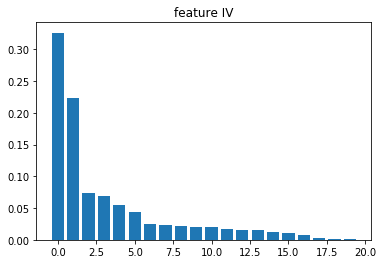

In [81]:
# 将变量IV值进行降序排列，方便后续挑选变量
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x: x[1], reverse=True)

IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]

import matplotlib.pyplot as plt
%matplotlib inline
plt.title('feature IV')
plt.bar(range(len(IV_values)), IV_values)
plt.show()